# 05- Forecasting with Exogenous Regressors


This notebook provides examples of the accepted data structures for passing the expected value of exogenous variables when these are included in the mean.  For example, consider an AR(1) with 2 exogenous variables. The mean dynamics are

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} + \beta_0 X_{0,t} + \beta_1 X_{1,t} + \epsilon_t. $$

The $h$-step forecast, $E_{T}[Y_{t+h}]$, depends on the conditional expectation of $X_{0,T+h}$ and $X_{1,T+h}$,

$$ E_{T}[Y_{T+h}] = \phi_0 + \phi_1 E_{T}[Y_{T+h-1}] + \beta_0 E_{T}[X_{0,T+h}] +\beta_1 E_{T}[X_{1,T+h}] $$

where $E_{T}[Y_{T+h-1}]$ has been recursively computed.

In order to construct forecasts up to some horizon $h$, it is necessary to pass $2\times h$ values ($h$ for each series).  If using the features of `forecast` that allow many forecast to be specified, it necessary to supply $n \times 2 \times h$ values.

There are two general purpose data structures that can be used for any number of exogenous variables and any number steps ahead:

* `dict` - The values can be pass using a `dict` where the keys are the variable names and the values are 2-dimensional arrays. This is the most natural generalization of a pandas `DataFrame` to 3-dimensions.
* `array` - The vales can alternatively be passed as a 3-d NumPy `array` where dimension 0 tracks the regressor index, dimension 1 is the time period and dimension 2 is the horizon.

When a model contains a single exogenous regressor it is possible to use a 2-d array or `DataFrame` where dim0 tracks the time period where the forecast is generated and dimension 1 tracks the horizon.

In the special case where a model contains a single regressor _and_ the horizon is 1, then a 1-d array of pandas Series can be used.

In [1]:
# initial setup
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from arch.__future__ import reindexing

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Simulating data

Two $X$ variables are simulated and are assumed to follow independent AR(1) processes. The data is then assumed to follow an ARX(1) with 2 exogenous regressors and GARCH(1,1) errors.

In [2]:
from arch.univariate import ARX, GARCH, ZeroMean, arch_model

burn = 250

x_mod = ARX(None, lags=1)
x0 = x_mod.simulate([1, 0.8, 1], nobs=1000 + burn).data
x1 = x_mod.simulate([2.5, 0.5, 1], nobs=1000 + burn).data

resid_mod = ZeroMean(volatility=GARCH())
resids = resid_mod.simulate([0.1, 0.1, 0.8], nobs=1000 + burn).data

phi1 = 0.7
phi0 = 3
y = 10 + resids.copy()
for i in range(1, y.shape[0]):
    y[i] = phi0 + phi1 * y[i - 1] + 2 * x0[i] - 2 * x1[i] + resids[i]

x0 = x0.iloc[-1000:]
x1 = x1.iloc[-1000:]
y = y.iloc[-1000:]
y.index = x0.index = x1.index = np.arange(1000)

## Plotting the data

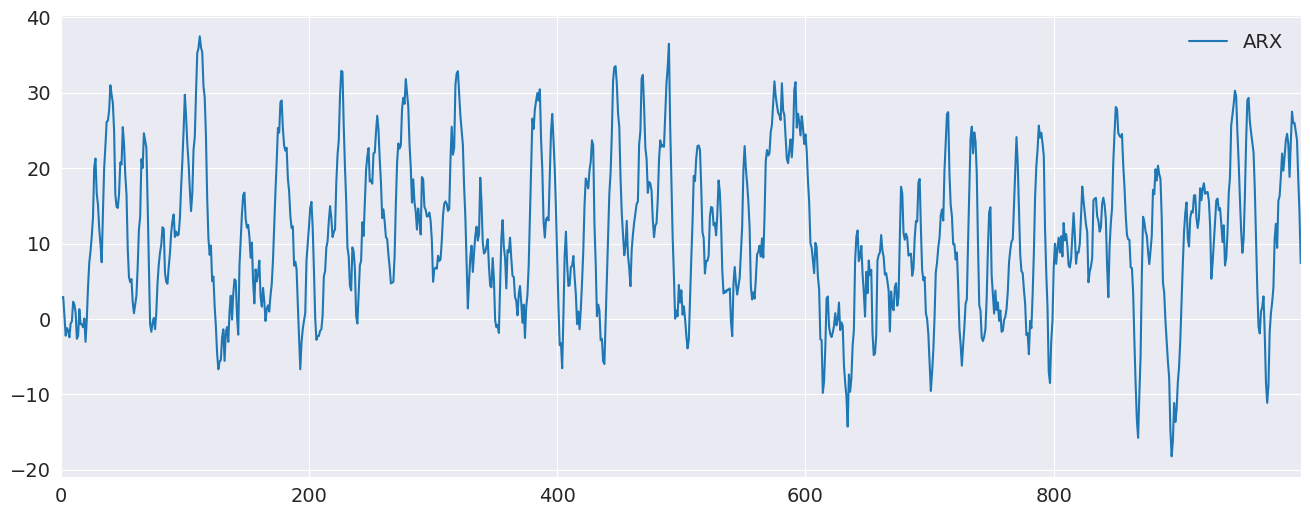

In [3]:
ax = pd.DataFrame({"ARX": y}).plot(legend=False)
ax.legend(frameon=False)
_ = ax.set_xlim(0, 999)

## Forecasting the X values

The forecasts of $Y$ depend on forecasts of $X_0$ and $X_1$.  Both of these follow simple AR(1), and so we can construct the forecasts for all time horizons.  Note that the value in position `[i,j]` is the time-`i` forecast for horizon `j+1`.

In [4]:
x0_oos = np.empty((1000, 10))
x1_oos = np.empty((1000, 10))
for i in range(10):
    if i == 0:
        last = x0
    else:
        last = x0_oos[:, i - 1]
    x0_oos[:, i] = 1 + 0.8 * last
    if i == 0:
        last = x1
    else:
        last = x1_oos[:, i - 1]
    x1_oos[:, i] = 2.5 + 0.5 * last

x1_oos[-1]

array([6.40619399, 5.70309699, 5.3515485 , 5.17577425, 5.08788712,
       5.04394356, 5.02197178, 5.01098589, 5.00549295, 5.00274647])

## Fitting the model

Next, the most is fit. The parameters are accurately estimated.

In [5]:
exog = pd.DataFrame({"x0": x0, "x1": x1})
mod = arch_model(y, x=exog, mean="ARX", lags=1)
res = mod.fit(disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   data   R-squared:                       0.990
Mean Model:                      AR-X   Adj. R-squared:                  0.990
Vol Model:                      GARCH   Log-Likelihood:               -1410.59
Distribution:                  Normal   AIC:                           2835.18
Method:            Maximum Likelihood   BIC:                           2869.52
                                        No. Observations:                  999
Date:                Thu, Apr 13 2023   Df Residuals:                      995
Time:                        19:15:54   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          2.8028      0.173     16.168  8.524e-59 [  2.463,  3.14

## Using a `dict`

The first approach uses a dict to pass the two variables. The key consideration here is the the keys of the dictionary must **exactly** match the variable names (`x0` and `x1` here).  The dictionary here contains only the final row of the forecast values since `forecast` will only make forecasts beginning from the final in-sample observation by default.

### Using `DataFrame`

While these examples make use of NumPy arrays, these can be `DataFrames`. This allows the index to be used to track the forecast origination point, which can be a helpful device.

<Axes: >

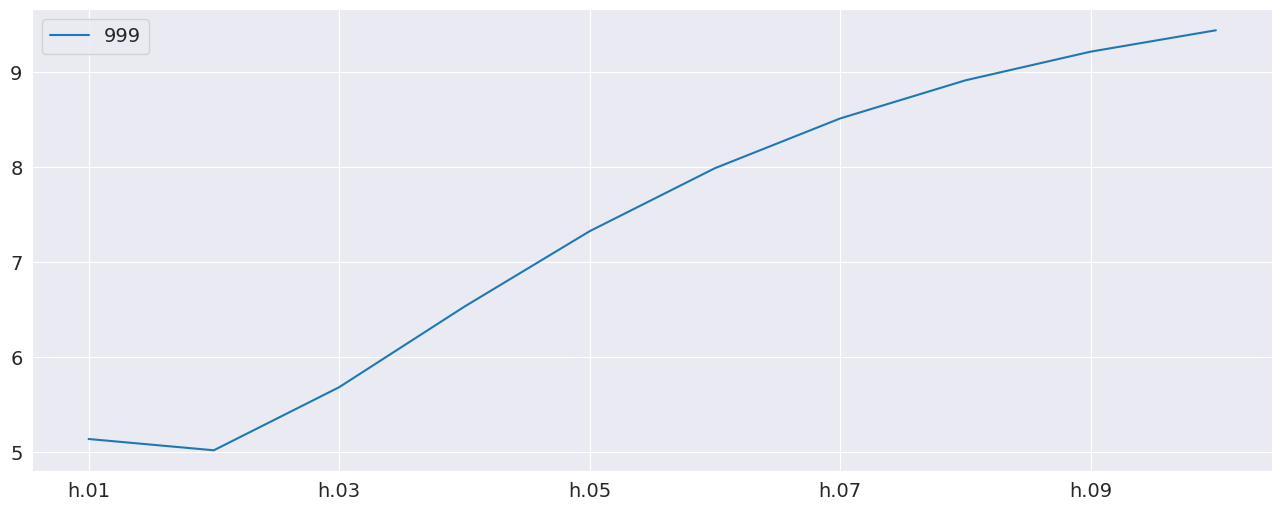

In [6]:
exog_fcast = {"x0": x0_oos[-1:], "x1": x1_oos[-1:]}
forecasts = res.forecast(horizon=10, x=exog_fcast)
forecasts.mean.T.plot()

## Using an `array`

An array can alternatively be used.  This frees the restriction on matching the variable names although the order must match instead. The forecast values are 2 (variables) by 1 (forecast) by 10 (horizon).

In [7]:
exog_fcast = np.array([x0_oos[-1:], x1_oos[-1:]])
print(f"The shape is {exog_fcast.shape}")
array_forecasts = res.forecast(horizon=10, x=exog_fcast)
print(array_forecasts.mean - forecasts.mean)

The shape is (2, 1, 10)
     h.01  h.02  h.03  h.04  h.05  h.06  h.07  h.08  h.09  h.10
999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


## Producing multiple forecasts

`forecast` can produce multiple forecasts using the same fit model.  Here the model is fit to the first 500 observations and then forecasting for the remaining values are produced. It must be the case that the `x` values passed for `forecast` have the same number of rows as the table of forecasts produced.


In [8]:
res = mod.fit(disp="off", last_obs=500)
exog_fcast = {"x0": x0_oos[-500:], "x1": x1_oos[-500:]}
multi_forecasts = res.forecast(start=500, horizon=10, x=exog_fcast)
multi_forecasts.mean.tail(10)

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
990,17.768107,16.946922,16.197231,15.476191,14.786258,14.141028,13.552482,13.027454,12.567724,12.171257
991,24.040271,23.354845,22.082136,20.607842,19.134562,17.762954,16.536924,15.469142,14.555624,13.784089
992,27.091122,25.524781,23.561863,21.578892,19.745783,18.127631,16.737462,15.563627,14.583994,13.773202
993,23.812686,22.023400,20.423123,18.970281,17.659939,16.494389,15.473029,14.590278,13.836399,13.199061
994,24.567110,23.089120,21.581584,20.102366,18.704939,17.425734,16.283759,15.284280,14.423127,13.690379
995,23.899440,22.212396,20.395973,18.692633,17.193092,15.916784,14.851630,13.973412,13.254962,12.670283
996,22.349193,20.949971,19.570587,18.261614,17.058860,15.981870,15.036975,14.221265,13.526097,12.939768
997,17.151909,16.099119,15.262889,14.545576,13.911619,13.349231,12.854087,12.423015,12.052037,11.736145
998,12.999678,12.560137,12.349736,12.192718,12.031221,11.855002,11.670150,11.486071,11.310725,11.149415
999,5.183529,5.078544,5.745759,6.597128,7.396405,8.066477,8.597945,9.006879,9.316143,9.547774


The plot of the final 5 forecast paths shows the the mean reversion of the process.

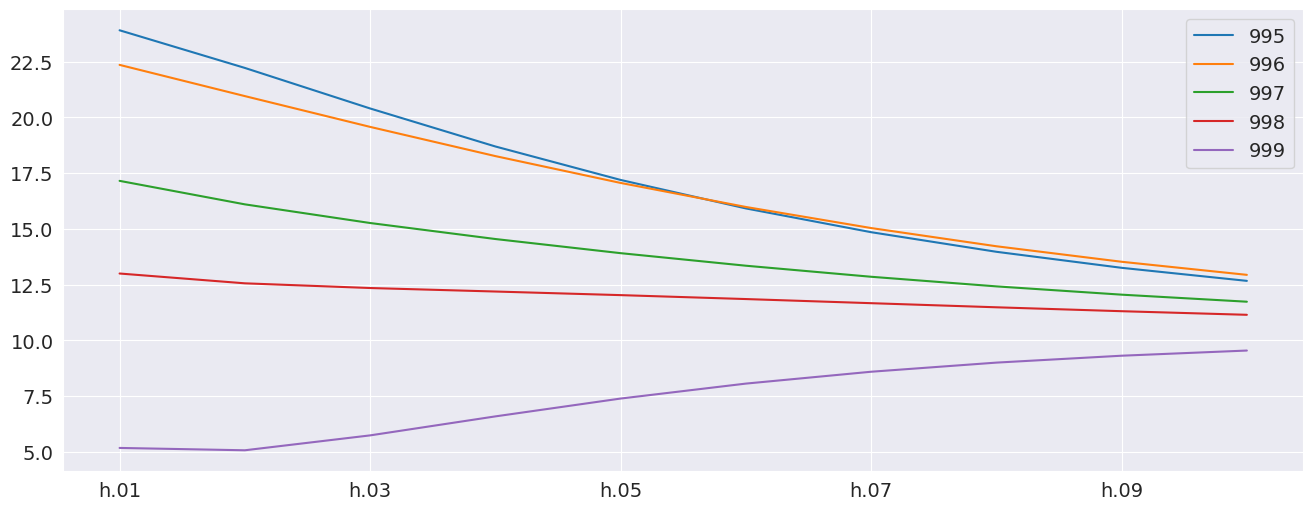

In [9]:
_ = multi_forecasts.mean.tail().T.plot()

The previous example made use of dictionaries where each of the values was a 500 (number of forecasts) by 10 (horizon) array.  The alternative format can be used where `x` is a 3-d array with shape 2 (variables) by 500 (forecasts) by 10 (horizon).

In [10]:
exog_fcast = np.array([x0_oos[-500:], x1_oos[-500:]])
print(exog_fcast.shape)
array_multi_forecasts = res.forecast(start=500, horizon=10, x=exog_fcast)
np.max(np.abs(array_multi_forecasts.mean - multi_forecasts.mean))

(2, 500, 10)


/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


h.01    0.0
h.02    0.0
h.03    0.0
h.04    0.0
h.05    0.0
h.06    0.0
h.07    0.0
h.08    0.0
h.09    0.0
h.10    0.0
dtype: float64

## `x` input array sizes

While the natural shape of the `x` data is the number of forecasts, it is also possible to pass an `x` that has the same shape as the `y` used to construct the model.  The may simplify tracking the origin points of the forecast.  Values are are not needed are ignored. In this example, the out-of-sample values are 2 by 1000 (original number of observations) by 10.  Only the final 500 are used. 

<div class="alert alert-warning">
    <h3><b>WARNING</b></h3>
    Other sizes are <b>not</b> allowed. The size of the out-of-sample data must either match the original data size or the number of forecasts.
</div>

In [11]:
exog_fcast = np.array([x0_oos, x1_oos])
print(exog_fcast.shape)
array_multi_forecasts = res.forecast(start=500, horizon=10, x=exog_fcast)
np.max(np.abs(array_multi_forecasts.mean - multi_forecasts.mean))

(2, 1000, 10)


/home/ubuntu/Documents/Projects/STI_FX_Intervention/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


h.01    0.0
h.02    0.0
h.03    0.0
h.04    0.0
h.05    0.0
h.06    0.0
h.07    0.0
h.08    0.0
h.09    0.0
h.10    0.0
dtype: float64

## Special Cases with a single `x` variable

When a model consists of a single exogenous regressor, then `x` can be a 1-d or 2-d array (or `Series` or `DataFrame`).

In [12]:
mod = arch_model(y, x=exog.iloc[:, :1], mean="ARX", lags=1)
res = mod.fit(disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   data   R-squared:                       0.945
Mean Model:                      AR-X   Adj. R-squared:                  0.945
Vol Model:                      GARCH   Log-Likelihood:               -2264.62
Distribution:                  Normal   AIC:                           4541.25
Method:            Maximum Likelihood   BIC:                           4570.69
                                        No. Observations:                  999
Date:                Thu, Apr 13 2023   Df Residuals:                      996
Time:                        19:15:54   Df Model:                            3
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         -6.6878      0.254    -26.295 2.171e-152 [ -7.186, -6.18

These two examples show that both formats can be used.

In [13]:
forecast_1d = res.forecast(horizon=10, x=x0_oos[-1])
forecast_2d = res.forecast(horizon=10, x=x0_oos[-1:])
print(forecast_1d.mean - forecast_2d.mean)

## Simulation-forecasting

mod = arch_model(y, x=exog, mean="ARX", lags=1, power=1.0)
res = mod.fit(disp="off")

     h.01  h.02  h.03  h.04  h.05  h.06  h.07  h.08  h.09  h.10
999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


## Simulation

`forecast` supports simulating paths. When forecasting a model with exogenous variables, the same value is used to in all mean paths.  If you wish to also simulate the paths of the `x` variables, these need to generated and then passed inside a loop. 

### Static out-of-sample `x`
This first example shows that variance of the paths when the same `x` values are used in the forecast. There is a sense the out-of-sample `x` are treated as deterministic.

In [14]:
x = {"x0": x0_oos[-1], "x1": x1_oos[-1]}
sim_fixedx = res.forecast(horizon=10, x=x, method="simulation", simulations=100)
sim_fixedx.simulations.values.std(1)

array([[1.03285916, 1.24499696, 1.32965875, 1.32028509, 1.42550966,
        1.41111563, 1.3797305 , 1.36759933, 1.46089913, 1.44387865]])

### Simulating the out-of-sample `x`

This example simulates distinct paths for the two exogenous variables and then simulates a single path.  This is then repeated 100 times.  We see that variance is much higher when we account for variation in the x data.

In [15]:
from numpy.random import RandomState


def sim_ar1(params: np.ndarray, initial: float, horizon: int, rng: RandomState):
    out = np.zeros(horizon)
    shocks = rng.standard_normal(horizon)
    out[0] = params[0] + params[1] * initial + shocks[0]
    for i in range(1, horizon):
        out[i] = params[0] + params[1] * out[i - 1] + shocks[i]
    return out


simulations = []
rng = RandomState(20210301)
for i in range(100):
    x0_sim = sim_ar1(np.array([1, 0.8]), x0.iloc[-1], 10, rng)
    x1_sim = sim_ar1(np.array([2.5, 0.5]), x1.iloc[-1], 10, rng)
    x = {"x0": x0_sim, "x1": x1_sim}
    fcast = res.forecast(horizon=10, x=x, method="simulation", simulations=1)
    simulations.append(fcast.simulations.values)

Finally the standard deviation is quite a bit larger. This is a most accurate value fo the long-run variance of the forecast residuals which should account for dynamics in the model and any exogenous regressors.

In [16]:
joined = np.concatenate(simulations, 1)
joined.std(1)

array([[3.08271317, 4.91814697, 6.58191987, 7.55695432, 8.42580117,
        8.83401628, 8.88820311, 9.112039  , 9.10556593, 9.25142055]])